In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
from sklearn.model_selection import train_test_split

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [264]:
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')
df = X.join(y)
df.head()

,engine,max_power,mileage,km_driven,selling_price
0,1248.0,74.00,23.40,145500,450000
1,1498.0,103.52,21.14,120000,370000
2,1497.0,78.00,17.70,140000,158000
3,1396.0,90.00,23.00,127000,225000
4,1298.0,88.20,16.10,120000,130000


In [268]:
df.isnull().sum()

engine           214
max_power        208
mileage          214
km_driven          0
selling_price      0
dtype: int64

In [270]:
df.dropna(inplace=True)
df.isna().sum()

engine           0
max_power        0
mileage          0
km_driven        0
selling_price    0
dtype: int64

In [3]:
df.dtypes

NameError: name 'df' is not defined

In [4]:

# X = pd.read_csv('X.csv')
# y = pd.read_csv('y.csv')
X = df[['engine','max_power','mileage','km_driven']]
y = df['selling_price']

print(y.max())
print(y.min())



NameError: name 'df' is not defined

In [276]:

#max_val, min_val = y.max(), y.min()
max_val, min_val = 1000000, 29999

n_bins = 4
bin_width = (max_val - min_val) / n_bins
bin_edges = [min_val + i * bin_width for i in range(n_bins + 1)]
bin_labels = [0, 1, 2, 3]
y = pd.cut(y, bins=bin_edges, labels=bin_labels, include_lowest=True)




In [279]:


X = X.fillna(X.mean())
X = X[~y.isna()]
y = y.dropna()


In [280]:
y.unique()

[1, 0, 3, 2]
Categories (4, int64): [0 < 1 < 2 < 3]

In [184]:
set(y)

{0, 1, 2, 3}

In [281]:
y.shape,X.shape

((7000,), (7000, 4))

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42 )
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(5250, 4) (1750, 4) (5250,) (1750,)


In [283]:

# y = y.drop(['selling_price'], axis=1)
# X = X[~y['price_bucket'].isna()]
# y = y['price_bucket'].dropna()


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# intercept = np.ones((X_train.shape[0], 1))
# X_train   = np.concatenate((intercept, X_train), axis=1)
# intercept = np.ones((X_test.shape[0], 1))
# X_test    = np.concatenate((intercept, X_test), axis=1)

k = len(set(y))
m = X_train.shape[0]
n = X_train.shape[1]
Y_train_encoded = np.zeros((m, k))
for each_class in range(k):
    cond = y_train==each_class
    Y_train_encoded[np.where(cond), each_class] = 1

y_train = pd.to_numeric(y_train)

y_test = pd.to_numeric(y_test)

In [284]:
y_test.shape

(1750,)

In [285]:
y_train.shape

(5250,)

In [286]:
X_train.shape

(5250, 4)

In [287]:
X.columns


Index(['engine', 'max_power', 'mileage', 'km_driven'], dtype='object')

In [288]:
X_train.shape

(5250, 4)

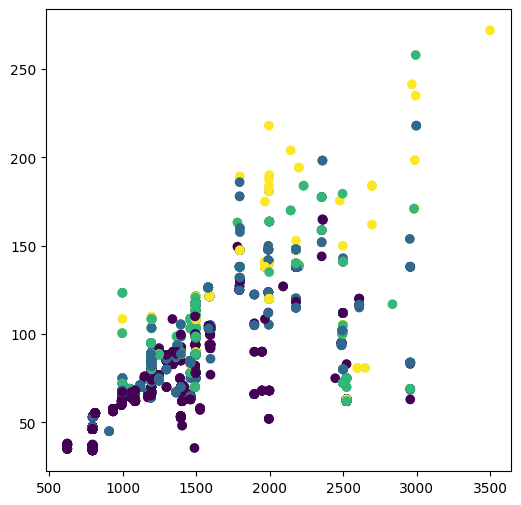

In [289]:
# Visualize our data
plt.figure(figsize=(6,6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], label='class 0', c=y)
plt.show()

In [318]:
#experiment tracking
import mlflow
import os
# This the dockerized method.
# We build two docker containers, one for python/jupyter and another for mlflow.
# The url `mlflow` is resolved into another container within the same composer.


#HERE, we write the code to access the mlflow server in order to save our models

# mlflow.set_tracking_uri("https://mlflow.ml.brain.cs.ait.ac.th/")
mlflow.set_tracking_uri("http://localhost:8080")


# os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
# os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"

os.environ["LOGNAME"] = "st125002_cassandra"

# mlflow.set_experiment(experiment_name="st125002_assignment2")

KeyboardInterrupt: 

In [312]:

# Function to compute precision, recall and f1-score for one class
def class_metrics(y_test, yhat, cls):
    # True Positives (TP): correct prediction for class cls
    tp = sum((yhat == cls) & (y_test == cls))
    # False Positives (FP): predicted class cls but actually another class
    fp = sum((yhat == cls) & (y_test != cls))
    # False Negatives (FN): didn't predict class cls but it was actually cls
    fn = sum((yhat != cls) & (y_test == cls))
    
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1 score: 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Function to calculate macro-averaged metrics
def macro_metrics(y_test, yhat, num_classes):
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    
    for cls in range(num_classes):
        precision, recall, f1 = class_metrics(np.array(y_test), np.array(yhat), cls)
        total_precision += precision
        total_recall += recall
        total_f1 += f1
    
    # Macro average is the mean of the metrics for all classes
    macro_precision = total_precision / num_classes
    macro_recall = total_recall / num_classes
    macro_f1 = total_f1 / num_classes
    
    return macro_precision, macro_recall, macro_f1

# Function to calculate class weights (frequency of each class in y_test)
def class_weights(y_test, num_classes):
    class_counts = np.bincount(y_test)
    total_samples = len(y_test)
    weights = class_counts / total_samples
    return weights

# Function to calculate weighted-averaged metrics
def weighted_metrics(y_test, yhat, num_classes):
    weights = class_weights(np.array(y_test), num_classes)
    total_weighted_precision = 0
    total_weighted_recall = 0
    total_weighted_f1 = 0
    
    for cls in range(num_classes):
        precision, recall, f1 = class_metrics(np.array(y_test), np.array(yhat), cls)
        weight = weights[cls]
        total_weighted_precision += precision * weight
        total_weighted_recall += recall * weight
        total_weighted_f1 += f1 * weight
    
    return total_weighted_precision, total_weighted_recall, total_weighted_f1


In [313]:

class LogisticRegression:

    def __init__(self, k, n, method, alpha = 0.01, max_iter=5000, ridge=False, lmbda=0.1):
        self.k = k
        self.n = n
        self.alpha = alpha
        self.max_iter = max_iter
        self.method = method
        self.ridge = ridge
        self.lmbda = lmbda

    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k) * 0.01
        self.losses = []

        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
                
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0])
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)

                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
                
            print(f"time taken: {time.time() - start_time}")

        elif self.method == "sto":
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad

                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")

        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')


    def gradient(self, X, Y):
        m = X.shape[0]
        H = self._predict(X, self.W)
        loss = -np.sum(Y*np.log(H)) / m
        grad = X.T @ (H - Y)

        # If ridge (L2 penalty) is enabled, modify the loss and gradient
        if self.ridge:
            # Add L2 penalty to the loss
            loss += (self.lmbda / (2 * m)) * np.sum(np.square(self.W))
            # Add L2 penalty to the gradient
            grad += (self.lmbda / m) * self.W

        return loss, grad

        return loss, grad
    
    def _predict(self, X, W):
        return self.softmax(X @ W)
    
    def softmax(self, theta_t_x):
        # theta_t_x[theta_t_x == 0] = 0.0001
        # print("softmax value:",np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True))
        # print()
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        # error[error == 0] = 0.0001
        return  X.T @ error

    def h_theta(self, X, W):
        # W[W == 0] = 0.0001
        # print("self.softmax in h_theta:",self.softmax(X@W))
        return self.softmax(X @ W)

    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)

    def plot(self):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()



In [314]:
np.unique(Y_train_encoded)

array([0., 1.])

Loss at iteration 0 1.3844770587608024
Loss at iteration 500 1.420820387449199
Loss at iteration 1000 1.224741458836567
Loss at iteration 1500 1.5006817755995752
Loss at iteration 2000 1.1843761341348544
Loss at iteration 2500 1.3253697961465276
Loss at iteration 3000 1.5277156888097079
Loss at iteration 3500 1.5035041701193839
Loss at iteration 4000 1.570172938888705
Loss at iteration 4500 1.5817294570401799
time taken: 0.35984325408935547
Macro Precision: 0.3890
Macro Recall: 0.4567
Macro F1 Score: 0.3871
Weighted Precision: 0.4205
Weighted Recall: 0.4594
Weighted F1 Score: 0.3977


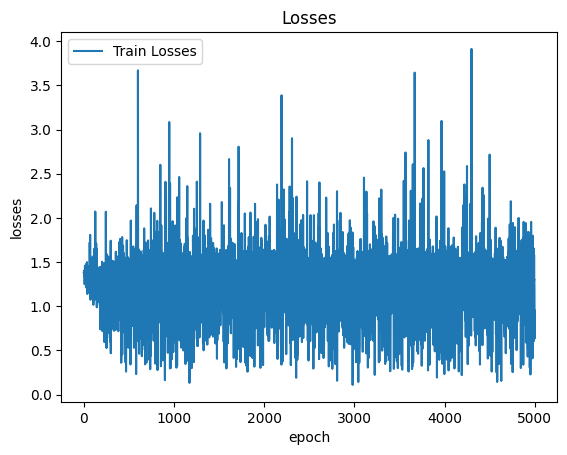

In [315]:
gradiant = ['sto'] #, 'minibatch', 'batch']


for grad in gradiant: 
    model = LogisticRegression(k, X_train.shape[1], method=grad, ridge=True, lmbda=0.1)
    model.fit(X_train, Y_train_encoded)
    yhat = model.predict(X_test)

    # Calculate macro-averaged metrics
    macro_precision, macro_recall, macro_f1 = macro_metrics(y_test, yhat, k)
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")

    # Calculate weighted-averaged metrics
    weighted_precision, weighted_recall, weighted_f1 = weighted_metrics(y_test, yhat, k)
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")

    model.plot()

In [302]:
print(accuracy_score(yhat, y_test))
print(precision(yhat, y_test))
print(recall(yhat, y_test))
print(f1_score(yhat, y_test))

0.4937142857142857
0.0005714285714285715
0.0005714285714285715
0.0005714285714285715


In [29]:
y_test.dtype

dtype('float64')